In [1]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline,
)
from peft import LoraConfig, get_peft_model
from datasets import Dataset
from sklearn.model_selection import train_test_split

/home/fall2023/pg2360/miniconda3/envs/mental_health_nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup Environment
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

print("Available GPUs:", torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device:", device)
print("Clear cache")
torch.cuda.empty_cache()

Available GPUs: 1
Using Device: cuda
Clear cache


In [3]:
class DataPreparation:
    def __init__(self, dataset_path, categories):
        self.dataset_path = dataset_path
        self.categories = categories
        self.df = None
        self.df_normal = None
        self.hf_dataset = None
        self.zero_shot_classifier = None

        # Determine the device to use
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if self.device.type == "cuda":
            current_device = torch.cuda.current_device()
            print(f"Using GPU: {torch.cuda.get_device_name(current_device)} (Device {current_device})")
        else:
            print("Using CPU for processing.")
        print(f"Device assigned to DataPreparation: {self.device}")

    def load_and_preprocess(self):
        print("Loading and preprocessing dataset...")
        # Load dataset
        self.df = pd.read_csv(self.dataset_path)

        # Preprocess dataset
        self.df['statement'] = self.df['statement'].fillna("")
        self.df = self.df[self.df['statement'].str.strip() != ""]
        self.df = self.df[self.df['status'] != "Suicidal"]
        self.df = self.df.reset_index(drop=True)

        # Handle rows with "Normal" status
        print("Handling rows with 'Normal' status...")
        self.df_normal = self.df[self.df['status'] == "Normal"].copy()
        self.df_normal['ZeroShot_Cause'] = "No Issues"
        self.df_normal['FineTuned_Cause'] = "No Issues"

        # Filter rows to exclude the "Normal" rows before processing
        self.df = self.df[self.df['status'] != "Normal"].copy()

        print("Dataset preprocessed. Ready for zero-shot classification.")
        self.hf_dataset = Dataset.from_pandas(self.df)
    
    # Zero shot Learning
    def zero_shot_classification(self):
        print("Performing zero-shot categorization using a single GPU...")
        zero_shot_model_name = "roberta-large-mnli"
        self.zero_shot_classifier = pipeline(
            "zero-shot-classification",
            model=zero_shot_model_name,
            device=0 if self.device.type == "cuda" else -1
        )

        # Classification function
        def classify(batch):
            try:
                results = self.zero_shot_classifier(batch["statement"], self.categories, truncation=True)
                batch["ZeroShot_Cause"] = [
                    result["labels"][0] if result["labels"] else "Unknown"
                    for result in results
                ]
            except Exception as e:
                print(f"Error classifying batch: {batch['statement']}. Error: {e}")
                batch["ZeroShot_Cause"] = ["Unknown"] * len(batch["statement"])
            return batch

        # Zero-shot classification with batch processing
        self.hf_dataset = self.hf_dataset.map(classify, batched=True, batch_size=8, num_proc=1)
        print("Zero-shot classification complete.")

    def save_zero_shot_results(self, filename):
        print(f"Saving zero-shot results to {filename}...")
        # Add the "Normal" rows back
        df_zero_shot = self.hf_dataset.to_pandas()
        df_final = pd.concat([df_zero_shot, self.df_normal], ignore_index=True)
        df_final.to_csv(filename, index=False)
        print(f"Zero-shot results saved to {filename}.")

In [4]:
# Define dataset path and categories
dataset_path = "MentalHealthDataset.csv"
categories = ["Health Issues", "Relationship Issues", "Financial Stress", "Workplace Stress", "Social Isolation"]

# Initialize and process
data_prep = DataPreparation(dataset_path, categories)
data_prep.load_and_preprocess()

# Perform zero-shot classification
data_prep.zero_shot_classification()

# Save results to CSV
data_prep.save_zero_shot_results("zero_shot_predictions.csv")

Using GPU: NVIDIA A16 (Device 0)
Device assigned to DataPreparation: cuda
Loading and preprocessing dataset...
Handling rows with 'Normal' status...
Dataset preprocessed. Ready for zero-shot classification.
Performing zero-shot categorization using a single GPU...


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/fall2023/pg2360/miniconda3/envs/mental_health_nlp/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` b

Zero-shot classification complete.
Saving zero-shot results to zero_shot_predictions.csv...
Zero-shot results saved to zero_shot_predictions.csv.


In [11]:
!pip install transformers

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import torch
from datasets import Dataset

# Load the zero-shot predictions CSV file
file_path = "zero_shot_predictions.csv"
df = pd.read_csv(file_path)

# Drop unnecessary columns
df = df.drop(columns=["__index_level_0__", "id", "FineTuned_Cause"], errors="ignore")

# Map causes to numerical labels
categories = ["Health Issues", "Relationship Issues", "Financial Stress", "Workplace Stress", "Social Isolation", "No Issues"]
label2id = {label: idx for idx, label in enumerate(categories)}
id2label = {idx: label for label, idx in label2id.items()}
df["label"] = df["ZeroShot_Cause"].map(label2id)

# Use the entire dataset for fine-tuning
train_texts = df["statement"].tolist()
train_labels = df["label"].tolist()

# Load MentalBERT tokenizer and model
mentalbert_model = "mental/mental-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(mentalbert_model)
model = AutoModelForSequenceClassification.from_pretrained(mentalbert_model, num_labels=len(categories))

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels}).map(tokenize_function, batched=True)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="no",  # No validation set
    save_strategy="epoch",     # Save model at the end of each epoch
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,  # Simulate an effective batch size of 16
    num_train_epochs=2,
    weight_decay=0.01,
    save_total_limit=1  # Keep only the most recent checkpoint
)


# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
)

# Train the model
trainer.train()

# Save the fine-tuned model
model.save_pretrained("fine_tuned_mentalbert_cause_classifier")
tokenizer.save_pretrained("fine_tuned_mentalbert_cause_classifier")

# Load the fine-tuned model for prediction
model = AutoModelForSequenceClassification.from_pretrained("fine_tuned_mentalbert_cause_classifier")
tokenizer = AutoTokenizer.from_pretrained("fine_tuned_mentalbert_cause_classifier")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Prediction function with device handling
def predict_cause(statement):
    inputs = tokenizer(statement, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to the same device as the model
    outputs = model(**inputs)
    predicted_label = torch.argmax(outputs.logits, dim=1).item()
    return id2label[predicted_label]

/home/fall2023/pg2360/miniconda3/envs/mental_health_nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fall2023/pg2360/miniconda3/envs/mental_health_nlp/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN

Step,Training Loss
500,0.737000
1000,0.599400
1500,0.565900
2000,0.528600
2500,0.518300
3000,0.374700
3500,0.317800
4000,0.302800
4500,0.302400
5000,0.287200


In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the fine-tuned model for prediction
model_path = "fine_tuned_mentalbert_cause_classifier"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the label mapping 
id2label = {0: "Health Issues", 1: "Relationship Issues", 2: "Financial Stress", 
            3: "Workplace Stress", 4: "Social Isolation", 5: "No Issues"}

# Cause Prediction 
def predict_cause(statement):
    inputs = tokenizer(statement, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to the same device as the model
    outputs = model(**inputs)
    predicted_label = torch.argmax(outputs.logits, dim=1).item()
    return id2label[predicted_label]

# Classify posts and update Predicted Cause
def classify_post(row):
    if row["Predicted Label"] == "Normal":
        return "No Issues"
    return predict_cause(row["statement"])

# Load the test dataset
test_file = "TestDatasetPredictions.csv"
test_df = pd.read_csv(test_file)

# Ensure the dataset contains the required columns
required_columns = {"statement", "Predicted Label"}
if not required_columns.issubset(test_df.columns):
    raise ValueError(f"The test dataset must contain these columns: {required_columns}")

# Generate the Predicted Cause column
test_df["Predicted Cause"] = test_df.apply(classify_post, axis=1)

# Save the updated test dataset
output_file = "test_data_with_predicted_cause.csv"
test_df.to_csv(output_file, index=False)
print(f"Predicted causes saved to '{output_file}'")

Predicted causes saved to 'test_data_with_predicted_cause.csv'


Frequency of Stressor Types:
         Stressor Type  Count
0            No Issues   9740
1  Relationship Issues   7909
2     Social Isolation   5219
3        Health Issues   2799
4     Financial Stress   1845
5     Workplace Stress    463


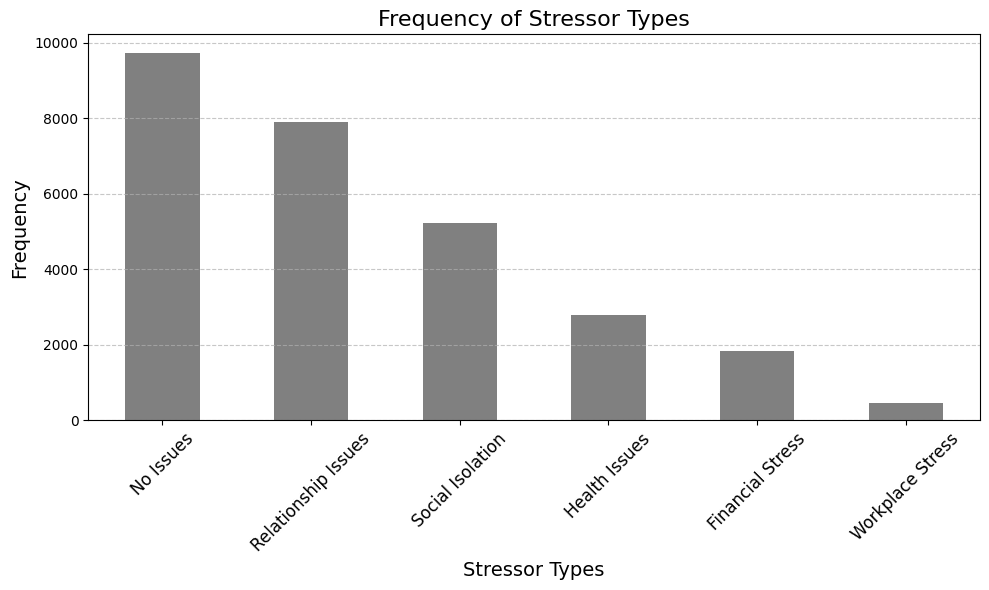

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the updated dataset
file_path = "test_data_with_predicted_cause.csv"
df = pd.read_csv(file_path)

# Calculate the frequency of each stressor type
stressor_counts = df["Predicted Cause"].value_counts()

# Display the count of each stressor type
stressor_counts_df = stressor_counts.reset_index()
stressor_counts_df.columns = ["Stressor Type", "Count"]
print("Frequency of Stressor Types:")
print(stressor_counts_df)

# Plot the top stressors
plt.figure(figsize=(10, 6))
stressor_counts.plot(kind='bar', color='gray')
plt.title("Frequency of Stressor Types", fontsize=16)
plt.xlabel("Stressor Types", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid for better readability
plt.tight_layout()
plt.show()

In [6]:
!pip install vaderSentiment

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

# Load the updated dataset
file_path = "test_data_with_predicted_cause.csv"
df = pd.read_csv(file_path)

# Initialize VADER SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Calculate urgency score based on VADER compound score
def calculate_urgency(statement):
    sentiment_scores = analyzer.polarity_scores(statement)
    compound_score = sentiment_scores['compound']
    
    # Normalize compound score to 1-10 scale and round to 2 decimal places
    urgency_score = round((compound_score + 1) * 5, 2)
    return urgency_score

# Calculate urgency scores where the label is not "Normal"
def apply_urgency_logic(row):
    if row['Predicted Label'] == "Normal":
        urgency_score = "NA"
        urgency_level = "Low"
        flag_for_assistance = "No"
    else:
        urgency_score = calculate_urgency(row['statement'])
        if urgency_score >= 7:
            urgency_level = "High"
            flag_for_assistance = "Yes"
        elif 4 <= urgency_score < 7:
            urgency_level = "Moderate"
            flag_for_assistance = "No"
        else:
            urgency_level = "Low"
            flag_for_assistance = "No"
    return pd.Series([urgency_score, urgency_level, flag_for_assistance])

df[['Urgency Score', 'Urgency Level', 'Flag for Assistance']] = df.apply(apply_urgency_logic, axis=1)

# Save the updated dataset
output_file = "test_data_with_urgency_flags.csv"
df.to_csv(output_file, index=False)
print(f"Updated dataset with urgency levels saved to '{output_file}'")

# Display the first few rows of the updated dataset
print(df.head())

Updated dataset with urgency levels saved to 'test_data_with_urgency_flags.csv'
                                           statement Predicted Label  \
0  dear american teens question dutch person hear...          Normal   
1  nothing look forward lifei dont many reasons k...      Depression   
2  music recommendations im looking expand playli...          Normal   
3  im done trying feel betterthe reason im still ...      Depression   
4  worried  year old girl subject domestic physic...      Depression   

       Predicted Cause Urgency Score Urgency Level Flag for Assistance  
0            No Issues            NA           Low                  No  
1     Financial Stress          7.11          High                 Yes  
2            No Issues            NA           Low                  No  
3        Health Issues           2.0           Low                  No  
4  Relationship Issues          0.01           Low                  No  


Counts of scenarios that require assistance and those that don't:
Flag for Assistance
No     21083
Yes     6892
Name: count, dtype: int64


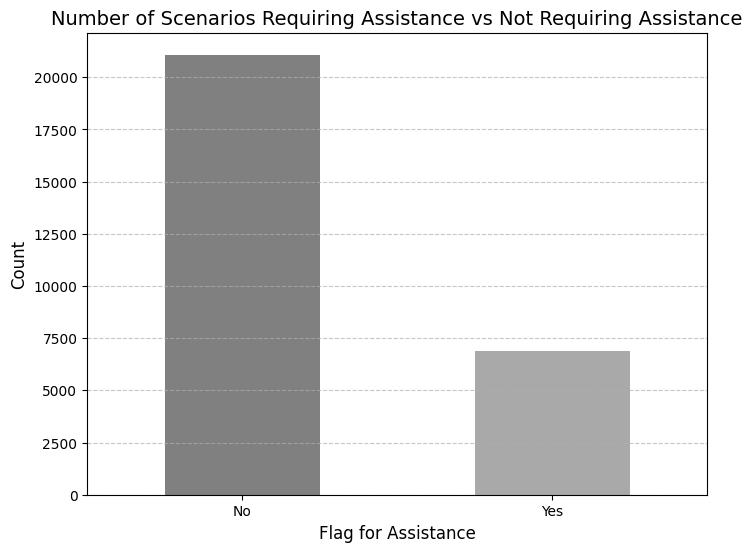

In [15]:
import matplotlib.pyplot as plt

# Load the updated dataset
file_path = "test_data_with_urgency_flags.csv"
df = pd.read_csv(file_path)

# Count the number of scenarios that require assistance and those that do not
assistance_counts = df['Flag for Assistance'].value_counts()
print("Counts of scenarios that require assistance and those that don't:")
print(assistance_counts)

# Plot the counts in grayscale
plt.figure(figsize=(8, 6))
assistance_counts.plot(kind='bar', color=['gray', 'darkgray'])  # Set grayscale colors
plt.title('Number of Scenarios Requiring Assistance vs Not Requiring Assistance', fontsize=14)
plt.xlabel('Flag for Assistance', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: Add grid for better readability
plt.show()